### Clustering

**Clase de problemas 27/10/20**

**Federico Davia**

#### Primeros pasos

Importamos librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.cluster import KMeans
import PIL
from matplotlib import image

from scipy.stats import zscore

print('Pillow Version:', PIL.__version__)

Pillow Version: 7.2.0


Definimos funciones auxiliares:

* **rgb_to_hsv**:convertir imagen rgb en hsv(Matiz, Saturación, Brillo).
* **hsv_to_rgb**: operacion opuesta.

Formula para la conversión:
https://es.wikipedia.org/wiki/Modelo_de_color_HSV

In [2]:
def rgb_to_hsv(rgb):
    """
    >>> from colorsys import rgb_to_hsv as rgb_to_hsv_single
    >>> 'h={:.2f} s={:.2f} v={:.2f}'.format(*rgb_to_hsv_single(50, 120, 239))
    'h=0.60 s=0.79 v=239.00'
    >>> 'h={:.2f} s={:.2f} v={:.2f}'.format(*rgb_to_hsv_single(163, 200, 130))
    'h=0.25 s=0.35 v=200.00'
    >>> np.set_printoptions(2)
    >>> rgb_to_hsv(np.array([[[50, 120, 239], [163, 200, 130]]]))
    array([[[   0.6 ,    0.79,  239.  ],
            [   0.25,    0.35,  200.  ]]])
    >>> 'h={:.2f} s={:.2f} v={:.2f}'.format(*rgb_to_hsv_single(100, 100, 100))
    'h=0.00 s=0.00 v=100.00'
    >>> rgb_to_hsv(np.array([[50, 120, 239], [100, 100, 100]]))
    array([[   0.6 ,    0.79,  239.  ],
           [   0.  ,    0.  ,  100.  ]])
    """
    input_shape = rgb.shape
    rgb = rgb.reshape(-1, 3)
    r, g, b = rgb[:, 0], rgb[:, 1], rgb[:, 2]

    maxc = np.maximum(np.maximum(r, g), b)
    minc = np.minimum(np.minimum(r, g), b)
    v = maxc

    deltac = maxc - minc
    s = deltac / maxc
    deltac[deltac == 0] = 1  # to not divide by zero (those results in any way would be overridden in next lines)
    rc = (maxc - r) / deltac
    gc = (maxc - g) / deltac
    bc = (maxc - b) / deltac

    h = 4.0 + gc - rc
    h[g == maxc] = 2.0 + rc[g == maxc] - bc[g == maxc]
    h[r == maxc] = bc[r == maxc] - gc[r == maxc]
    h[minc == maxc] = 0.0

    h = (h / 6.0) % 1.0
    res = np.dstack([h, s, v])
    return res.reshape(input_shape)


def hsv_to_rgb(hsv):
    """
    >>> from colorsys import hsv_to_rgb as hsv_to_rgb_single
    >>> 'r={:.0f} g={:.0f} b={:.0f}'.format(*hsv_to_rgb_single(0.60, 0.79, 239))
    'r=50 g=126 b=239'
    >>> 'r={:.0f} g={:.0f} b={:.0f}'.format(*hsv_to_rgb_single(0.25, 0.35, 200.0))
    'r=165 g=200 b=130'
    >>> np.set_printoptions(0)
    >>> hsv_to_rgb(np.array([[[0.60, 0.79, 239], [0.25, 0.35, 200.0]]]))
    array([[[  50.,  126.,  239.],
            [ 165.,  200.,  130.]]])
    >>> 'r={:.0f} g={:.0f} b={:.0f}'.format(*hsv_to_rgb_single(0.60, 0.0, 239))
    'r=239 g=239 b=239'
    >>> hsv_to_rgb(np.array([[0.60, 0.79, 239], [0.60, 0.0, 239]]))
    array([[  50.,  126.,  239.],
           [ 239.,  239.,  239.]])
    """
    input_shape = hsv.shape
    hsv = hsv.reshape(-1, 3)
    h, s, v = hsv[:, 0], hsv[:, 1], hsv[:, 2]

    i = np.int32(h * 6.0)
    f = (h * 6.0) - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))
    i = i % 6

    rgb = np.zeros_like(hsv)
    v, t, p, q = v.reshape(-1, 1), t.reshape(-1, 1), p.reshape(-1, 1), q.reshape(-1, 1)
    rgb[i == 0] = np.hstack([v, t, p])[i == 0]
    rgb[i == 1] = np.hstack([q, v, p])[i == 1]
    rgb[i == 2] = np.hstack([p, v, t])[i == 2]
    rgb[i == 3] = np.hstack([p, q, v])[i == 3]
    rgb[i == 4] = np.hstack([t, p, v])[i == 4]
    rgb[i == 5] = np.hstack([v, p, q])[i == 5]
    rgb[s == 0.0] = np.hstack([v, v, v])[s == 0.0]

    return rgb.reshape(input_shape)


#### Procesando la imagen

**OBS**: Para ver los resultados con otras imagenes simplemente debemos cambiar el nombre de la imagen en la siguiente celda de código.

In [3]:
foto1 = image.imread('DSC01536.jpg')
foto1.shape

(2304, 3072, 3)

Tenemos una imagen de **2304px** x **3072px** , con tres canales cada pixel (rgb).

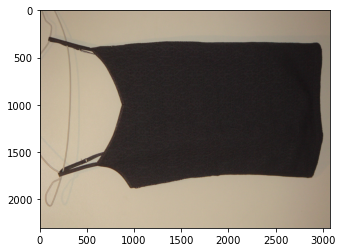

In [4]:
plt.figure()
plt.imshow(foto1)
plt.show()

Nos quedamos con solo algunos de los puntos (saltos de a 'dsamp').

In [5]:
dsamp=15
foto_apil1=foto1[::dsamp,::dsamp,:]
print('La imagen que usaremos para hacer clustering tiene {}px x {}px'.format(foto_apil1.shape[0],foto_apil1.shape[1]))

La imagen que usaremos para hacer clustering tiene 154px x 205px


Cambiamos a formato hsv las fotos. Para ello usamos la funcion auxiliar `rgb_to_hsv`.

In [6]:
foto_hsi=rgb_to_hsv(foto_apil1)

# Calculamos nro de filas y columnas
(fil,col)=foto_hsi.shape[:2]

# Reordenamos la matriz
H=foto_hsi.reshape(-1,3,order='F')

#### Analizamos distribuciones

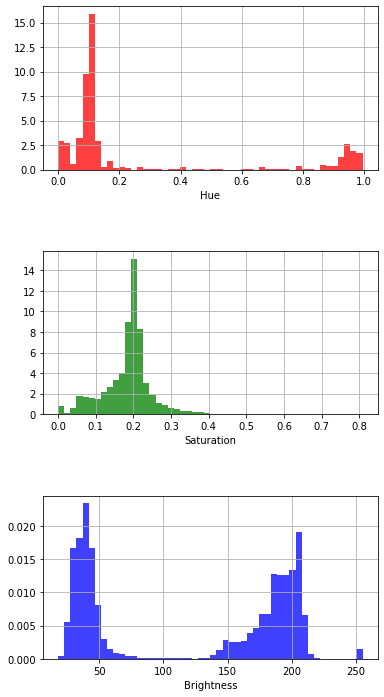

In [7]:
fig, axs = plt.subplots(3,gridspec_kw={'hspace': 0.5},figsize=(6,12))

axs[0].hist(H[:,0],50, density=True, facecolor='r', alpha=0.75)
axs[1].hist(H[:,1],50, density=True, facecolor='g', alpha=0.75)
axs[2].hist(H[:,2],50, density=True, facecolor='b', alpha=0.75)

for n,ax in enumerate(axs):
    ax.set_xlabel(str(['Hue', 'Saturation', 'Brightness'][n]))
    ax.grid(True)
plt.show()

#### Aplicamos el modelo

Vamos a ver el efecto de normalizar las variables de forma que estén en la misma escala.

In [8]:
H_zscore = zscore(H)

Usamos clustering variando el número de clusters y vemos el efecto en la suma de errores cuadraticos.

In [9]:
# Datos sin normalizar
errores_cuadraticos=[]
K=range(1,8)

for k in K:
    km = KMeans(n_clusters=k)
    km.fit(H)
    errores_cuadraticos.append(km.inertia_)

#Datos Normalizados
errores_cuadraticos_norm=[]
K_norm=range(1,8)

for k in K_norm:
    km = KMeans(n_clusters=k)
    km.fit(H_zscore)
    errores_cuadraticos_norm.append(km.inertia_)

Graficamos los resultados para cada caso:

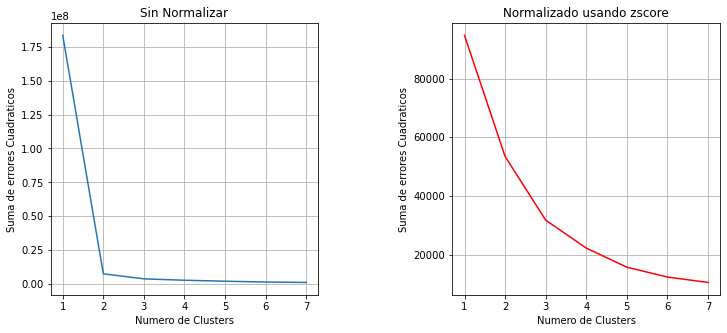

In [10]:
fig_2, axs_2 = plt.subplots(1,2,gridspec_kw={'wspace': 0.5,'hspace': 0.5},figsize=(12,5))

axs_2[0].plot(K,errores_cuadraticos)
axs_2[1].plot(K_norm,errores_cuadraticos_norm,color='r')

for n,ax in enumerate(axs_2):
    ax.set_xlabel('Numero de Clusters')
    ax.set_ylabel('Suma de errores Cuadraticos')
    ax.set_title(['Sin Normalizar','Normalizado usando zscore'][n])
    ax.grid(True)
plt.show()

Se puede ver que el efecto de aplicar zscore hace más dificil encontrar el numero de clusters óptimo. Esto no necesariamente quiere decir que el primer el primer modelo separe mejor los pixeles. Cuando no normalizamos la variable que define la ubicacion de los centroides es siempre 'Brightness' por una cuestion de escala. Al normalizar le damos el mismo peso a todas las variables.

En el primer caso elegimos usar **2 clusters** y en el segundo **3 clusters**.

In [11]:
#Sin normalizar
km = KMeans(n_clusters=2)
km.fit(H)

#Normalizando
km_norm = KMeans(n_clusters=3)
km_norm.fit(H_zscore)

KMeans(n_clusters=3)

Veamos qué puntos de la imagen pertencen a cada cluster. Primero asignamos el label (cluster al que pertenece) a cada pixel. Para ello debemos devolverle las dimensiones de la foto al vector.

In [12]:
#Sin normalizar
T = km.labels_
mT =T.reshape(fil,col,order='F')

#Normalizando
T_norm = km_norm.labels_
mT_norm =T_norm.reshape(fil,col,order='F')

Graficamos y comparamos con la imagen original:

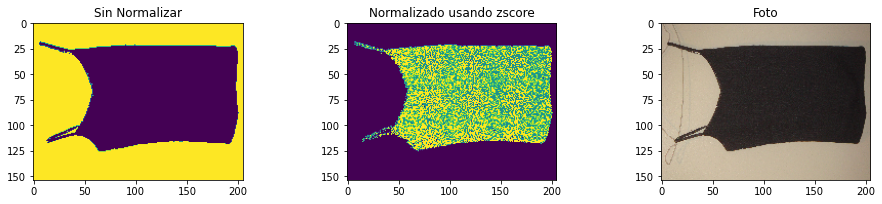

In [13]:
fig_3, axs_3 = plt.subplots(1,3,gridspec_kw={'wspace': 0.5,'hspace': 0.5},figsize=(15,5))

axs_3[0].imshow(mT)
axs_3[1].imshow(mT_norm)
axs_3[2].imshow(foto_apil1)

for n,ax in enumerate(axs_3):
    ax.set_title(['Sin Normalizar','Normalizado usando zscore','Foto'][n])
plt.show()


A priori no hay un efecto indudablemente positivo por usar zscore.

Por último, vemos como asigna los clusters cuando graficamos todos los puntos.

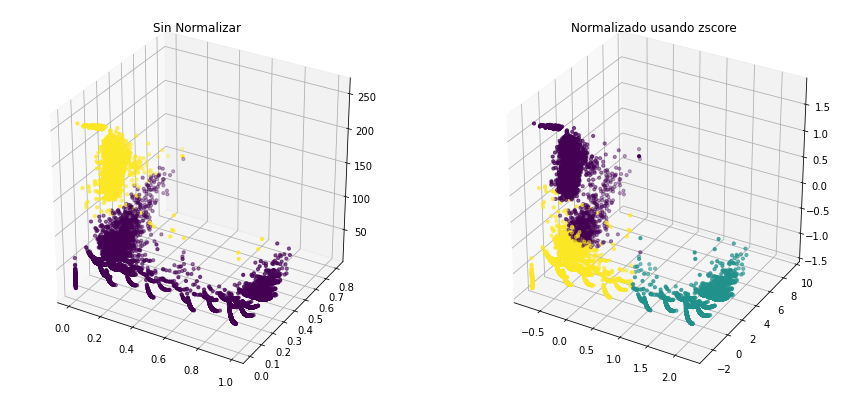

In [14]:
fig_4 = plt.figure(figsize=(15,7))
axs_4=[0,0]

axs_4[0] = fig_4.add_subplot(121, projection='3d')
axs_4[1] = fig_4.add_subplot(122, projection='3d')

axs_4[0].scatter(H[:,0],H[:,1],H[:,2], s=10, c=km.labels_, marker='o')  
axs_4[1].scatter(H_zscore[:,0],H_zscore[:,1],H_zscore[:,2], s=10, c=km_norm.labels_, marker='o') 

for n,ax in enumerate(axs_4):
    ax.set_title(['Sin Normalizar','Normalizado usando zscore'][n])

plt.show(fig_4)

#### Efecto de agregar la posicion de cada pixel

Para esto debemos generar una matriz con la posicion de cada pixel y concatenarla con H.

In [16]:
# Armamos los array de filas y columnas
posicion=[]
for fila in range(0,foto_hsi.shape[0]):
    for columna in range(0,foto_hsi.shape[1]):
        posicion.append([fila,columna])
posicion = np.array(posicion)

Concatenamos el vector H con el nuevo vector que contiene la posicion de cada pixel en la imagen.

In [17]:
H_con_pos = np.concatenate([H,posicion],axis=1)
H_con_pos_norm = zscore(H_con_pos)

In [18]:
#Datos con posicion
errores_cuadraticos_con_pos=[]
K_con_pos=range(1,8)

for k in K_con_pos:
    km_con_pos = KMeans(n_clusters=k)
    km_con_pos.fit(H_con_pos)
    errores_cuadraticos_con_pos.append(km_con_pos.inertia_)
    
#Datos con posicion norm
errores_cuadraticos_con_pos_norm=[]
K_con_pos_norm=range(1,8)

for k in K_con_pos_norm:
    km_con_pos_norm = KMeans(n_clusters=k)
    km_con_pos_norm.fit(H_con_pos_norm)
    errores_cuadraticos_con_pos_norm.append(km_con_pos_norm.inertia_) 

Graficamos la suma de errores cuadraticos en función del número de clusters.

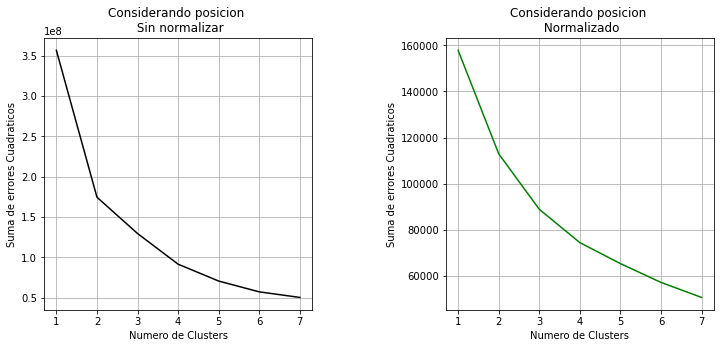

In [19]:
fig_5, axs_5 = plt.subplots(1,2,gridspec_kw={'wspace': 0.5,'hspace': 0.5},figsize=(12,5))
axs_5[0].plot(K_con_pos,errores_cuadraticos_con_pos,color='k')
axs_5[1].plot(K_con_pos,errores_cuadraticos_con_pos_norm,color='g')

for n,ax in enumerate(axs_5):
    ax.set_xlabel('Numero de Clusters')
    ax.set_ylabel('Suma de errores Cuadraticos')
    ax.set_title(['Considerando posicion \n Sin normalizar','Considerando posicion \n Normalizado'][n])
    ax.grid(True)
plt.show()

Vamos como los modelos separaron los puntos de la imagen.

Entrenamos con la cantidad de clusters correspondientes:

In [20]:
# Sin normalizar (usamos 3 clusters)
km_con_pos = KMeans(n_clusters=3)
km_con_pos.fit(H_con_pos)

# Normalizando (usamos 4 clusters)
km_con_pos_norm = KMeans(n_clusters=4)
km_con_pos_norm.fit(H_con_pos_norm)

KMeans(n_clusters=4)

Generamos las matrices con los labels de los pixeles:

In [21]:
#Label de cada punto sin normalizar
T_con_pos = km_con_pos.labels_
mT_con_pos =T_con_pos.reshape(fil,col,order='F')

#Label de cada punto normalizado
T_con_pos_norm = km_con_pos_norm.labels_
mT_con_pos_norm =T_con_pos_norm.reshape(fil,col,order='F')

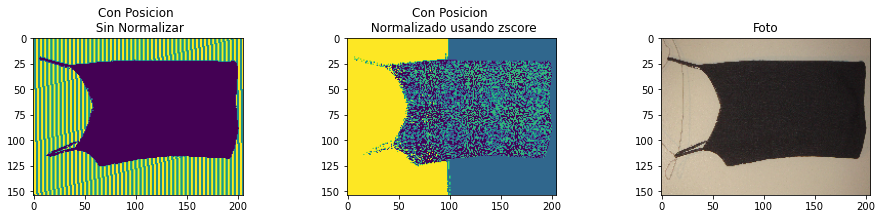

In [22]:
fig_6, axs_6 = plt.subplots(1,3,gridspec_kw={'wspace': 0.5,'hspace': 0.5},figsize=(15,5))

axs_6[0].imshow(mT_con_pos)
axs_6[1].imshow(mT_con_pos_norm)
axs_6[2].imshow(foto_apil1)

for n,ax in enumerate(axs_6):
    ax.set_title(['Con Posicion \n Sin Normalizar','Con Posicion \n Normalizado usando zscore','Foto'][n])
plt.show()


Quedo algo muy psicodélico!